# Comparing different algos for ts prediction <a name="toc"></a>

In this notebook we try to predict the number of tomorrows page views for one URL from looking only at daily page views from the previous 35 days (i.e. the previous five weeks) training on a total of approx. 1.5 years of daily traffic volumes. We fit various algorithms and benchmark their performance. 

This notebook proceeds as follows:

0. [EXPLORE DATA](#ed) - Fetch, explore, and preprocess data
1. [BENCHMARK MODEL](#bm) - Simple benchmark on weekly averages
2. [REGRESSION MODELS](#rm) - Linear regression, ARIMA
3. [FACEBOOK PROPHET](#fp) - FB Prophet with daily seasonality
4. [TREE BASED MODELS](#tbm) - Random Forest, Ada boost, Gradient Boosting, xgBoost
5. [NEURAL NETS](#nn) - MLP, Conv1D, LSTM, Mixed DL architecture
6. [FINDINGS](#f) - Benchmarking algorithm performance

## 1. EXPLORE DATA <a name="ed"></a>

This analysis leverages a simple univariate time series reporting 1.5 years of daily page views on the Wikipedia German main page ranging from July 2015 until the end of 2016 (chart below). This time series can be fetched from kaggle via this [link](https://www.kaggle.com/c/web-traffic-time-series-forecasting/data).

### Fetch Data

In [19]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

%matplotlib inline

warnings.filterwarnings("ignore", category=FutureWarning)

In [20]:
# Pull kaggle data on traffic volume for various Wikipedia pages
# wikipedia_traffic = pd.read_csv('train_1.csv')

# Extract timeseries (ts) of daily traffic on Wikipedia German main page
# ts = wikipedia_traffic.loc[139119, :]
# ts = ts[1:]
# ts = ts.astype('int64')

# Log daily DE traffic locally
# ts.to_csv('traffic_wikipedia_mainpage_DE.csv')

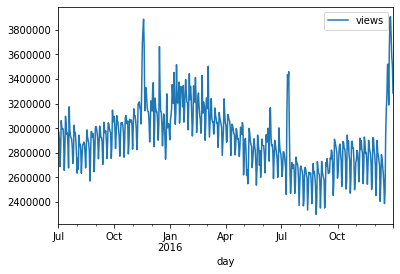

In [21]:
# Pull timeseries (ts) of daily DE traffic
ts = pd.read_csv('traffic_wikipedia_mainpage_DE.csv', header=None)
ts.columns = ['day', 'views']
ts.day = pd.to_datetime(ts.day)
ts.set_index('day', inplace=True)
ts.plot()

We are testing model performance on predictions for the last three weeks of data. We remove the spike at the very end to make sure we look at a testing period without anomalies.

In [22]:
ts = ts.iloc[:530,:]

### Differencing and Stationarity

First, we difference the timeseries in order to remove obvious long-term trends displayed in the graph above.

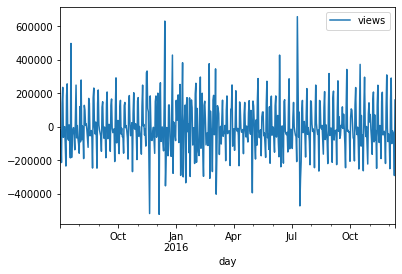

In [23]:
ts_diff = ts.diff()[1:]
ts_diff.plot()

Next, we perform the augmented Dickey-Fuller test to check whether the differenced time series is stationary.

- **Null Hypothesis (H0):** If failed to be rejected; it suggests the time series is non-stationary. It has some time dependent structure.
- **Alternate Hypothesis (H1):** The null hypothesis is rejected; it suggests the time series has no time-dependent structure.

We interpret this result using the p-value from the test. A p-value below a threshold (such as 5% or 1%) suggests we reject the null hypothesis (stationary), otherwise a p-value above the threshold suggests we fail to reject the null hypothesis (non-stationary). For diving deeper into this topic, check out this nice [blog-post](https://machinelearningmastery.com/time-series-data-stationary-python/).

In [24]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(ts_diff.views.values)
print('p-value: %f' % result[1])

p-value: 0.000000


The p-value is below 1% and we infer that the differenced time series is stationary and we are good to go for using this time series for fitting our algorithms below.

### Seasonality

Next, we explore whether the differenced time series still exhibits some seasonality w.r.t. weekday. We normalize the average weekday difference by the number of average daily page views. By normalizing the average weekday differences we can interpret them as percentage change of volumes. 

The chart below displays a strong lift in average daily page views of +6% for Monday (weekday=0) relative to Sunday (weekday=6). Saturday (weekday=5) exhibits a clear drop of average daily page views relative to Friday of -6%. The chart seems to suggest that Sunday is a strong day as well. However, this is only true relative to Saturday. The interpretation of the chart has to be done with some caution. The bars do not report average daily page views, but they report change of average page views relative to the previous day. Hence, the chart reports a high number of page views during the week. Monday is 6% stronger than Sunday and there is only little change in between Monday, Tuesday, Wednesday, Thursday and Friday. This means that these days exhibit a similar level of page views as Monday. However, being a little bit more precise, we see a small steady downward trend during the week. Then there is a big drop from Friday to Saturday. This drop is somewhat balanced from Saturday to Sunday. However, Sunday still remains at a significant lower level than Monday.

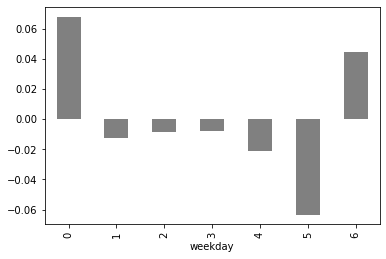

In [25]:
avg_views = ts.views.mean()
ts_diff['weekday'] = list(ts_diff.reset_index().day.dt.dayofweek)
(ts_diff.groupby('weekday').views.mean()/avg_views).plot.bar(color='grey')

0 = Monday, 1 = Tuesday, 2 = Wednesday, ...

Repeating the same exercise for months instead of weekdays we can not recover any significant seasonality. There are only fluctuations at a level below 0.5% differences relative to average daily volumes. This does not suggest any underlying pattern.

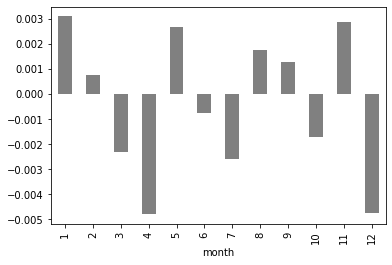

In [26]:
ts_diff['month'] = list(ts_diff.reset_index().day.dt.month)
(ts_diff.groupby('month').views.mean()/avg_views).plot.bar(color='grey')

In [27]:
ts_diff.drop(columns=['weekday', 'month'], inplace=True)

### Reshape Data

For training algorithms on this dataset we need to transform it and split it into distinct observations each consisting of feature target pairs. As the data exhibits a strong weekly periodicity we want the features comprise several weeks. Somewhat arbitrarily we will go for five weeks. Hence, we use a window of successive 35 days of data as features and the successive 36th day as target. Moving this 36-day window through the differenced time series we generate 493 observations for model training and testing.

In [28]:
X, y = [], []
for i in range(ts_diff.shape[0] - 36):
    X.append(list(ts_diff.views[i:i+35]))
    y.append(ts_diff.views[35+i])
    
X = pd.DataFrame(X)
y = pd.Series(y)

print(X.shape)
print(y.shape)

(493, 35)
(493,)


### Normalize Data

Normalizing time series data is somewhat more delicate than normalizing usual cross sectional data. We can not normalize observation number 4 w.r.t. to the total observation average and standard deviation. Doing this would entail information leakage: We would inject implicit information about future values into this normalized observation number 4. We could infer whether or not observation number 4 is large or small relative to future values. This is something we need to avoid. Hence, we restrict the normalization of each observation to past values only (i.e. to earlier observations). This is what we do next. For each observation we calculate average and standard deviation for all observations that are known up to this point and use these values for normalization.

In [29]:
norm = []
for i in range(ts_diff.shape[0] - 36):
    m_avg = ts_diff.views[:i+34].mean()
    m_std = ts_diff.views[:i+34].std()
    X.loc[i, :] = (X.loc[i, :] - m_avg) / m_std
    y[i] = (y[i] - m_avg) / m_std
    norm.append([m_avg, m_std])
    
# Log normalization parameters for calculating RMSE in original magnitute
norm = pd.DataFrame(norm, columns=['m_avg', 'm_std'])

### Train Test Split

Again we need to be extra cautious splitting off reasonable testing data. For time series the standard procedure of splitting off random observations for testing entails the risk of information leakage. We do not want the algorithm to train on future observations and use those learnings for predicting past observations. Hence, we need to cut our observations at a specific point in time and use past observations for training and future observations for testing.

In [30]:
testing_period = 21

train_period = y.shape[0] - testing_period
X_train, X_test, y_train, y_test = X.iloc[:train_period, :], X.iloc[train_period:, :], \
                                   y[:train_period], y[train_period:]

# Only keep normalization factors for testing period
norm = norm.tail(testing_period)
norm.reset_index(drop=True, inplace=True)

## 2. BENCHMARK MODEL <a name="bm"></a>
Back to [table of contents](#toc).

The time series exhibits strong seasonality w.r.t. weekdays. Hence, a canonical benchmark candidate simply predicts weekday averages. For each observation $x\in X$ we calculate the weekday averages and use the corresponding weekday average for predicting the target $y$.

In [31]:
def benchmark(x):
    # Extract target weekday values
    target_weekday_values = []
    for i in range(5):
        target_weekday_values.append(x[7*i])
        
    # Return average for target weekday
    return np.mean(target_weekday_values)

Next, we determine the RMSE in the original magnitude of daily differences. Hence, we need to apply the inverse normalization to both predictions and targets. Finally we log the RMSE and the relative RMSE (relative to the standard deviation of daily differences) in the list `rmse_models`. This list is used to log the results for all algorithms and for producing the final comparison table.

In [32]:
def rmse(predictions, targets, norm):
    predictions_orig = pd.Series(predictions).reset_index(drop=True).multiply(norm.m_std).add(norm.m_avg)
    targets_orig = pd.Series(targets).reset_index(drop=True).multiply(norm.m_std).add(norm.m_avg)
    return np.sqrt(((predictions_orig.subtract(targets_orig)) ** 2).mean())

def diff(predictions, targets, norm):
    predictions_orig = pd.Series(predictions).reset_index(drop=True).multiply(norm.m_std).add(norm.m_avg)
    targets_orig = pd.Series(targets).reset_index(drop=True).multiply(norm.m_std).add(norm.m_avg)
    return list(predictions_orig - targets_orig)

y_pred = []
for i in range(X_test.shape[0]):
    y_pred.append(benchmark(X_test.iloc[i, :]))

# Print model performance
print('\nRMSE of benchmark model: ' + str(rmse(y_pred, y_test, norm)))


RMSE of benchmark model: 44151.86859010721


In [33]:
# Log outcomes for algortihm benchmarking
rmse_models = []
diff_models = []
rmse_models.append(['Benchmark', rmse(y_pred, y_test, norm), rmse(y_pred, y_test, norm) \
                    / ts_diff[:-testing_period].views.std()])
diff_models.append(diff(y_pred, y_test, norm))

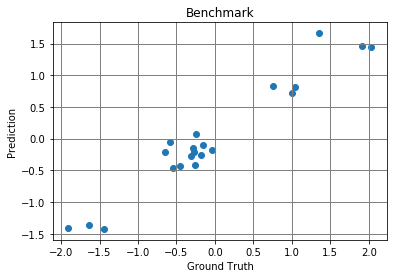

In [34]:
def scatter(x, y, title):
    plt.scatter(x=x, y=y)
    plt.title(title)
    plt.xlabel('Ground Truth')
    plt.ylabel('Prediction')
    plt.grid(color='gray', linestyle='-', linewidth=1)
    
scatter(y_test, y_pred, 'Benchmark')

## 3. REGRESSION MODELS <a name="rm"></a>
Back to [table of contents](#toc).

### Multiple Linear Regression

We fit a canonical multiple linear regression predicting the target (the next day) by determining an optimal multiplicative weight for each feature (the 35 proceeding days).

In [35]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression().fit(X_train, y_train)
y_pred = linreg.predict(X_test)

# Log outcomes for algortihm benchmarking
rmse_models.append(['Linear Regression', rmse(y_pred, y_test, norm), \
                    rmse(y_pred, y_test, norm) / ts_diff[:-testing_period].views.std()])
diff_models.append(diff(y_pred, y_test, norm))

# Print model performance
print('\nRMSE of multiple linear regression: ' + str(rmse(y_pred, y_test, norm)))


RMSE of multiple linear regression: 53429.11729338459


### ARIMA

In contrast to common out-of-the-box scikit-learn algorithms, ARIMA is not fit on feature-target-pairs. ARIMA is fitted directly to the time series via predicting tomorrows value from previous historical observations. As we want to benchmark best fitted versions of algorithms, we calculate ARIMA predictions by fitting the model to the complete time series history up to the day we want to forecast. Besides, fitting ARIMA on the above feature-target-pairs does not entail convergence and produces an error as these time series chunks of 35 observations are too short. Furthermore, ARIMA is not sensitive to normalization. I fitted the model both on normalized and on non-normalized data with no difference in performance. Hence, we fit the model to the original data for keeping the code simple and concise.

ARIMA stands for Auto-Regressive Integrated Moving Averages. The predictors depend on the parameters (p,d,q) of the ARIMA model:
- **p - the number of AR terms:** AR terms are lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
- **q - the number of MA terms:** MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.
- **d - the number of Differences:** These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate the same results.

We use ACF and the PACF plots for determining candidates for p and q. The ACF (Autocorrelation Function) is a measure of the correlation between the the time series with a lagged version of itself. For instance at lag 5, ACF would compare series at time instant ‘t1’…’t2’ with series at instant ‘t1-5’…’t2-5’ (t1-5 and t2 being end points).
The PACF (Partial Autocorrelation Function) measures the correlation between the time series with a lagged version of itself but after eliminating the variations already explained by the intervening comparisons. E.g. at lag 5, it will check the correlation but remove the effects already explained by lags 1 to 4. Candidate values for p and q can be inferred from the first crossing of the ACF and the PACF with the corresponding confidence interval. In our case this yields values of p=1 and q=1.

For more in-depth information on ARIMA time series forecasting have a look at this [blog-post](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/) and at this [blog-post](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/). This is also the source for some of the content in this section.

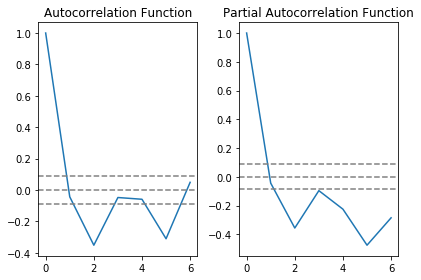

In [36]:
from statsmodels.tsa.stattools import acf, pacf

#ts_arima = (ts_diff[:-testing_period] - ts_diff[:-14].mean()) / ts_diff[:-14].std()
ts_arima = ts_diff[:-testing_period]

lag_acf = acf(ts_arima, nlags=6)
lag_pacf = pacf(ts_arima, nlags=6, method='ols')

# Plot ACF
plt.subplot(121) 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_arima)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_arima)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

# Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_arima)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_arima)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Next, we calculate a rolling forecast (fitting a separat ARIMA for each prediction) and determine the RMSE.

In [37]:
from statsmodels.tsa.arima_model import ARIMA

p, d, q = 1, 0, 1

y_pred_arima = []
y_test_arima = []
for i in range(testing_period):
    # Generate timeseries for training and testing
    ts_arima = ts_diff[:i-testing_period]
    y_test_arima.append(ts_diff.iloc[i-testing_period, 0])
    # Fit ARIMA
    arima_ = ARIMA(ts_arima, order=(p, d, q), freq='D')
    arima_fitted = arima_.fit(disp=0)
    # Log forecast for next day
    y_pred_arima.append(arima_fitted.forecast()[0][0])

# We skip normalization and set all normalization factors to 1
norm_arima = pd.DataFrame([[1, 1] for i in range(testing_period)], columns=['m_avg', 'm_std'])

print('\nRMSE of ARIMA: ' + str(rmse(y_pred_arima, y_test_arima, norm_arima)))


RMSE of ARIMA: 138743.60212543505


In [38]:
# Log outcomes for algortihm benchmarking
rmse_models.append(['Arima', rmse(y_pred_arima, y_test_arima, norm_arima), \
                    rmse(y_pred_arima, y_test_arima, norm_arima) / ts_diff[:-testing_period].views.std()])
diff_models.append(diff(y_pred_arima, y_test_arima, norm_arima))

The RMSE is surprisingly poor. Hence, I performed various checks to verify if model training is set-up correctly. It seems ARIMA is indeed a very poor predictor for this time series. Plotting the predictions of the final ARIMA model against the ground truth in the chart below, we can verify that the model picks up the most prominent pattern within the data but doesn't do a very good at hitting the correct magnitude.

Text(0.5, 0, '')

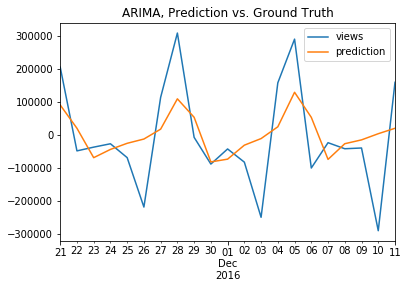

In [39]:
arima_plot = ts_diff.tail(testing_period).copy()
arima_plot['prediction'] = list(arima_fitted.predict().tail(testing_period))
arima_plot.plot()
plt.title('ARIMA, Prediction vs. Ground Truth')
plt.xlabel('')

## 4. FACEBOOK PROPHET <a name="fp"></a>
Back to [table of contents](#toc).

Analogously to fitting the ARIMA model above, we're using all past observations (relative to the observation to be predicted) for fitting the model and calculate a rolling forecast (i.e. fitting a new model for each prediction). Furthermore - also for the same reasons as outlined above - we refrain from normalizing the data.

In [40]:
from fbprophet import Prophet

y_pred_fbp = []
y_test_fbp = []
for i in range(testing_period):
    # Generate timeseries for training and testing
    ts_fbp = ts_diff[:i-testing_period].reset_index()
    ts_fbp.columns = ['ds', 'y']
    y_test_fbp.append(ts_diff.iloc[i-testing_period, 0])
    # Fit FB Prophet
    fbp = Prophet(daily_seasonality=True, yearly_seasonality=False)
    fbp.fit(ts_fbp)
    # Log forecast for next day
    next_observation = fbp.make_future_dataframe(periods=1).tail(1)
    forecast = fbp.predict(next_observation)
    y_pred_fbp.append(forecast.yhat[0])

# We skip normalization and set all normalization factors to 1
norm_fbp = pd.DataFrame([[1, 1] for i in range(testing_period)], columns=['m_avg', 'm_std'])

# Print model performance
print('\nRMSE of fb prophet: ' + str(rmse(y_pred_fbp, y_test_fbp, norm_fbp)))

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.



RMSE of fb prophet: 50103.61379622246


In [41]:
# Log outcomes for algortihm benchmarking
rmse_models.append(['FB Prophet', rmse(y_pred_fbp, y_test_fbp, norm_fbp), \
                    rmse(y_pred_fbp, y_test_fbp, norm_fbp) / ts_diff[:-testing_period].views.std()])
diff_models.append(diff(y_pred_fbp, y_test_fbp, norm_fbp))

## 5. TREE BASED MODELS <a name="tbm"></a>
Back to [table of contents](#toc).

### Random Forest

We conduct a randomized search for neighboring hyperparamaters around the SkLearn defaults and try to improving model performance. Furthermore, we simultaneously conduct a 5-fold cross-validation for reducing the risk of overfitting.

In [42]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Print model performance
print('Default hyperparameters: ' + str(regressor.get_params()))
print('\nRMSE w/o tuning: ' + str(rmse(regressor.predict(X_test), y_test, norm)))

Default hyperparameters: {'bootstrap': True, 'criterion': 'mse', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 10, 'n_jobs': None, 'oob_score': False, 'random_state': 42, 'verbose': 0, 'warm_start': False}

RMSE w/o tuning: 52362.194245376326


In [43]:
from sklearn.model_selection import RandomizedSearchCV

# Specify hyperparameter grid
params = {'n_estimators': range(260, 400, 20),
          'max_features': range(2, 4),
          'min_samples_split': range(4, 7)}

# Conduct gridsearch
random_search = RandomizedSearchCV(regressor, param_distributions=params, \
                                   scoring='neg_mean_absolute_error', iid=False, cv=5, n_iter=40)
random_search.fit(X_train, y_train)

# Create predictions
y_pred = random_search.predict(X_test)

# Print model performance
print('Tuned hyperparameters: ' + str(random_search.best_params_))
print('\nRMSE of tuned model: ' + str(rmse(y_pred, y_test, norm)))

Tuned hyperparameters: {'n_estimators': 340, 'min_samples_split': 6, 'max_features': 2}

RMSE of tuned model: 47097.93290411215


In [44]:
# Log outcomes for algortihm benchmarking
rmse_models.append(['Random Forest', rmse(y_pred, y_test, norm), \
                    rmse(y_pred, y_test, norm) / ts_diff[:-testing_period].views.std()])
diff_models.append(diff(y_pred, y_test, norm))

### Ada Boost

Again we conduct a randomized search for neighboring hyperparamaters around the SkLearn defaults and perform a 5-fold cross-validation for reducing the risk of overfitting. [Article comparing AdaBoost, gradient Boost, and xgBoost](https://hackernoon.com/boosting-algorithms-adaboost-gradient-boosting-and-xgboost-f74991cad38c)

In [45]:
from sklearn.ensemble import AdaBoostRegressor

regressor = AdaBoostRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Print model performance
print('Default hyperparameters: ' + str(regressor.get_params()))
print('\nRMSE w/o tuning: ' + str(rmse(regressor.predict(X_test), y_test, norm)))

Default hyperparameters: {'base_estimator': None, 'learning_rate': 1.0, 'loss': 'linear', 'n_estimators': 50, 'random_state': 42}

RMSE w/o tuning: 66324.59050809247


In [46]:
# Specify hyperparameter grid
params = {'n_estimators': range(20, 200, 20),
          'learning_rate': [i/10 for i in range(1, 20, 2)],
          'loss': ['linear', 'square', 'exponential']}

# Conduct gridsearch
random_search = RandomizedSearchCV(regressor, param_distributions=params, \
                                   scoring='neg_mean_absolute_error', iid=False, cv=5, n_iter=40)
random_search.fit(X_train, y_train)

# Create predictions
y_pred = random_search.predict(X_test)

# Print model performance
print('Tuned hyperparameters: ' + str(random_search.best_params_))
print('\nRMSE of tuned model: ' + str(rmse(y_pred, y_test, norm)))

Tuned hyperparameters: {'n_estimators': 20, 'loss': 'exponential', 'learning_rate': 0.7}

RMSE of tuned model: 63663.113081188916


In [47]:
# Log outcomes for algortihm benchmarking
rmse_models.append(['Ada Boost', rmse(y_pred, y_test, norm), \
                    rmse(y_pred, y_test, norm) / ts_diff[:-testing_period].views.std()])
diff_models.append(diff(y_pred, y_test, norm))

### Gradient Boost

Again we conduct a randomized search for neighboring hyperparamaters around the SkLearn defaults and perform a 5-fold cross-validation for reducing the risk of overfitting.

In [48]:
from sklearn.ensemble import GradientBoostingRegressor

regressor = GradientBoostingRegressor(random_state=42)
regressor.fit(X_train, y_train)

# Print model performance
print('Default hyperparameters: ' + str(regressor.get_params()))
print('\nRMSE w/o tuning: ' + str(rmse(regressor.predict(X_test), y_test, norm)))

Default hyperparameters: {'alpha': 0.9, 'criterion': 'friedman_mse', 'init': None, 'learning_rate': 0.1, 'loss': 'ls', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_iter_no_change': None, 'presort': 'auto', 'random_state': 42, 'subsample': 1.0, 'tol': 0.0001, 'validation_fraction': 0.1, 'verbose': 0, 'warm_start': False}

RMSE w/o tuning: 60480.132228863695


In [49]:
# Specify hyperparameter grid
params = {'n_estimators': range(20, 200, 20),
          'learning_rate': [i/10 for i in range(1, 20, 2)],
          'loss': ['ls', 'lad', 'huber', 'quantile']}

# Conduct gridsearch
random_search = RandomizedSearchCV(regressor, param_distributions=params, \
                                   scoring='neg_mean_absolute_error', iid=False, cv=5, n_iter=40)
random_search.fit(X_train, y_train)

# Create predictions
y_pred = random_search.predict(X_test)

# Print model performance
print('Tuned hyperparameters: ' + str(random_search.best_params_))
print('\nRMSE of tuned model: ' + str(rmse(y_pred, y_test, norm)))

Tuned hyperparameters: {'n_estimators': 180, 'loss': 'lad', 'learning_rate': 0.1}

RMSE of tuned model: 54857.19972042632


In [50]:
# Log outcomes for algortihm benchmarking
rmse_models.append(['Gradient Boost', rmse(y_pred, y_test, norm), \
                    rmse(y_pred, y_test, norm) / ts_diff[:-testing_period].views.std()])
diff_models.append(diff(y_pred, y_test, norm))

### xg Boost

Again we conduct a randomized search for neighboring hyperparamaters around the xgb defaults and perform a 5-fold cross-validation for reducing the risk of overfitting.

In [51]:
from xgboost import XGBRegressor

regressor = XGBRegressor()
regressor.fit(X_train, y_train)

# Print model performance
print('Default hyperparameters: ' + str(regressor.get_params()))
print('\nRMSE w/o tuning: ' + str(rmse(regressor.predict(X_test), y_test, norm)))

[09:41:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Default hyperparameters: {'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bynode': 1, 'colsample_bytree': 1, 'gamma': 0, 'importance_type': 'gain', 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 3, 'min_child_weight': 1, 'missing': None, 'n_estimators': 100, 'n_jobs': 1, 'nthread': None, 'objective': 'reg:linear', 'random_state': 0, 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': None, 'silent': None, 'subsample': 1, 'verbosity': 1}

RMSE w/o tuning: 55960.38318345194


In [52]:
# Specify hyperparameter grid
params = {'learning_rate': [i/100 for i in range(1, 30, 5)],
          'max_depth': range(5),
          'subsample ': [i/10 for i in range(4, 12, 2)]}

# Conduct gridsearch
random_search = RandomizedSearchCV(regressor, param_distributions=params, \
                                   scoring='neg_mean_absolute_error', iid=False, cv=5, n_iter=100)
random_search.fit(X_train, y_train)

# Create predictions
y_pred = random_search.predict(X_test)

# Print model performance
print('Tuned hyperparameters: ' + str(random_search.best_params_))
print('\nRMSE of tuned model:' + str(rmse(y_pred, y_test, norm)))

[09:41:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:41:58] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[09:42:05] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:06] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[09:42:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:11] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:12] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[09:42:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:20] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[09:42:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:26] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[09:42:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:33] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

[09:42:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:40] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:42:41] WARNING: src/objective/regression_obj.cu:152: reg:linear is n

In [53]:
# Log non-tuned model as it exhibits better performance
y_pred = regressor.predict(X_test)

# Log outcomes for algortihm benchmarking
rmse_models.append(['XG Boost', rmse(y_pred, y_test, norm), \
                    rmse(y_pred, y_test, norm) / ts_diff[:-testing_period].views.std()])
diff_models.append(diff(y_pred, y_test, norm))

## 6. NEURAL NETS <a name="nn"></a>
Back to [table of contents](#toc).

The last section of this notebook explores the efficiency of neural nets on this task of predicting univariate time series given few training observations only. We construct four different architectures. First, a simple multi layer perceptron (MLP) that solely adds another dense layer, plus a dropout to the multiple linear regression discussed above. Second, a convolutional neural net based on 1-dimensional filters (according to the time series dimensionality). Third, a recurrent neural net consisting of one LSTM layer. Fourth, a mixed architecture featuring both a convolutional pipeline and a LSTM pipeline which are concatenated into a single dense layer.


### MLP
We fit a simple multi layer perceptron with only one hidden layer. We conduct grid search on the number of hidden neurons and the subsequent dropout rate.

In [54]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping

# Split off validation data and initialize early stopping for avoiding overfitting
X_fit, X_val, y_fit, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)
earlystopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Setup gridsearch
def grid_search(neurons, dropouts):
    grid_results = []
    best_fit_val_loss = 0
    for neuron in neurons:
        for dropout in dropouts:
            # Define DL architecture
            model = Sequential()
            model.add(Dense(neuron, activation='relu', input_shape=(X_train.shape[1],)))
            model.add(Dropout(dropout))
            model.add(Dense(1))
            # Compile and fit model
            model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])  
            model.fit(X_fit, y_fit, validation_data=(X_val, y_val), epochs=1000, callbacks=[earlystopping], verbose=0)
            # Log grid results
            grid_results.append([neuron, dropout, model.history.history['loss'][-1], model.history.history['val_loss'][-1]])
            # Log best model w.r.t. val_loss
            if (best_fit_val_loss==0) or (best_fit_val_loss>model.history.history['val_loss'][-1]):
                best_fit = model
                best_fit_val_loss = model.history.history['val_loss'][-1]
    return best_fit, pd.DataFrame(grid_results, columns=['neurons', 'dropout', 'train_loss', 'val_loss'])

# Specify hyperparameter grid
neurons = range(8,12)
dropouts = [i/100 for i in range(1, 30, 5)]

# Conduct gridsearch
best_fit, grid_results = grid_search(neurons, dropouts)

# Create predictions
y_pred = pd.DataFrame(best_fit.predict(X_test)).iloc[:, 0]

# Report model performance
tuned_params = grid_results.loc[grid_results.val_loss==grid_results.val_loss.min()]
print('Tuned hyperparameters: ' + 'neurons ' + str(float(tuned_params.neurons)) \
                                + ', dropout ' + str(float(tuned_params.dropout)))
print('\nRMSE of tuned model: ' + str(rmse(y_pred, y_test, norm)))
print('\nPercentaged validation-loss-reduction achieved by tuning: ' + \
      str(round(100 * (grid_results.val_loss.min() / grid_results.val_loss.max() -1), 2)))

Tuned hyperparameters: neurons 9.0, dropout 0.01

RMSE of tuned model: 47026.39613694954

Percentaged validation-loss-reduction achieved by tuning: -19.18


In [55]:
# Log outcomes for algortihm benchmarking
rmse_models.append(['MLP', rmse(y_pred, y_test, norm), \
                    rmse(y_pred, y_test, norm) / ts_diff[:-testing_period].views.std()])
diff_models.append(diff(y_pred, y_test, norm))

### Conv1D
We fit a convolutional neural net with only one convolutional layer. We conduct grid search on the number of filters, kernels and the subsequent dropout rate.

In [56]:
from keras.layers import Conv1D, MaxPooling1D, Flatten

# Model input shape
n_timesteps, n_features = X_train.shape[1], 1

# Setup gridsearch
def grid_search(filters_, kernels, dropouts):
    grid_results = []
    best_fit_val_loss = 0
    for filter_ in filters_:
        for kernel in kernels:
            for dropout in dropouts:
                # Define DL architecture
                model = Sequential()
                model.add(Conv1D(filters=filter_, kernel_size=kernel, padding='same', activation='relu', \
                                 input_shape=(n_timesteps, n_features)))
                model.add(MaxPooling1D(pool_size=2))
                model.add(Flatten())
                model.add(Dropout(dropout))
                model.add(Dense(1))
                # Compile and fit model
                model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])  
                model.fit(np.expand_dims(X_fit, axis=2), y_fit, \
                          validation_data=(np.expand_dims(X_val, axis=2), y_val), \
                          epochs=1000, callbacks=[earlystopping], verbose=0)
                # Log grid results
                grid_results.append([filter_, kernel, dropout, model.history.history['loss'][-1], \
                                     model.history.history['val_loss'][-1]])
                # Log best model w.r.t. val_loss
                if (best_fit_val_loss==0) or (best_fit_val_loss>model.history.history['val_loss'][-1]):
                    best_fit = model
                    best_fit_val_loss = model.history.history['val_loss'][-1]
    return best_fit, pd.DataFrame(grid_results, columns=['filters', 'kernel', 'dropout', 'train_loss', 'val_loss'])

# Specify hyperparameter grid
filters_ = range(9,12)
kernels = range(9,12)
dropouts = [i/10 for i in range(1, 5)]

# Conduct gridsearch
best_fit, grid_results = grid_search(filters_, kernels, dropouts)

# Create predictions
y_pred = pd.DataFrame(best_fit.predict(np.expand_dims(X_test, axis=2))).iloc[:, 0]

# Print model performance
tuned_params = grid_results.loc[grid_results.val_loss==grid_results.val_loss.min()]
print('Tuned hyperparameters: ' + 'filters ' + str(float(tuned_params.filters)) \
                                + ', kernel ' + str(float(tuned_params.kernel)) \
                                + ', dropout ' + str(float(tuned_params.dropout)))
print('\nRMSE of tuned model: ' + str(rmse(y_pred, y_test, norm)))
print('\nPercentaged validation-loss-reduction achieved by tuning: ' + \
      str(round(100 * (grid_results.val_loss.min() / grid_results.val_loss.max() -1), 2)))

Tuned hyperparameters: filters 9.0, kernel 11.0, dropout 0.2

RMSE of tuned model: 45692.30966483463

Percentaged validation-loss-reduction achieved by tuning: -11.36


In [57]:
# Log outcomes for algortihm benchmarking
rmse_models.append(['Conv1D', rmse(y_pred, y_test, norm), \
                    rmse(y_pred, y_test, norm) / ts_diff[:-testing_period].views.std()])
diff_models.append(diff(y_pred, y_test, norm))

### LSTM
We fit a recurrent neural net with only one LSTM layer. We conduct grid search on the number of units, on the internal dropout rate, and the subsequent dropout rate.

In [58]:
from keras.layers import LSTM

# Setup gridsearch
def grid_search(units, rec_dropouts, dropouts):
    grid_results = []
    best_fit_val_loss = 0
    for unit in units:
        for rec_dropout in rec_dropouts:
            for dropout in dropouts:
                # Define DL architecture
                model = Sequential()
                model.add(LSTM(unit, activation='tanh', recurrent_activation='hard_sigmoid', \
                               dropout=dropout, recurrent_dropout=rec_dropout, input_shape=(n_timesteps, n_features)))
                model.add(Dense(1))
                # Compile and fit model
                model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])  
                model.fit(np.expand_dims(X_fit, axis=2), y_fit, \
                          validation_data=(np.expand_dims(X_val, axis=2), y_val), \
                          epochs=1000, callbacks=[earlystopping], verbose=0)
                # Log grid results
                grid_results.append([unit, rec_dropout, dropout, model.history.history['loss'][-1], \
                                     model.history.history['val_loss'][-1]])
                # Log best model w.r.t. val_loss
                if (best_fit_val_loss==0) or (best_fit_val_loss>model.history.history['val_loss'][-1]):
                    best_fit = model
                    best_fit_val_loss = model.history.history['val_loss'][-1]
    return best_fit, pd.DataFrame(grid_results, columns=['units', 'rec_dropout', 'dropout', 'train_loss', 'val_loss'])

# Specify hyperparameter grid
units = range(9, 12)
rec_dropouts = [i/10 for i in range(1, 5)]
dropouts = [i/10 for i in range(1, 5)]

# Conduct gridsearch
best_fit, grid_results = grid_search(units, rec_dropouts, dropouts)

# Create predictions
y_pred = pd.DataFrame(best_fit.predict(np.expand_dims(X_test, axis=2))).iloc[:, 0]

# Print model performance
tuned_params = grid_results.loc[grid_results.val_loss==grid_results.val_loss.min()]
print('Tuned hyperparameters: ' + 'units ' + str(float(tuned_params.units)) \
                                + ', rec_dropout ' + str(float(tuned_params.rec_dropout)) \
                                + ', dropout ' + str(float(tuned_params.dropout)))
print('\nRMSE of tuned model: ' + str(rmse(y_pred, y_test, norm)))
print('\nPercentaged validation-loss-reduction achieved by tuning: ' + \
      str(round(100 * (grid_results.val_loss.min() / grid_results.val_loss.max() -1), 2)))

Tuned hyperparameters: units 11.0, rec_dropout 0.3, dropout 0.1

RMSE of tuned model: 82991.34303917861

Percentaged validation-loss-reduction achieved by tuning: -31.43


In [59]:
# Log outcomes for algortihm benchmarking
rmse_models.append(['LSTM', rmse(y_pred, y_test, norm), \
                    rmse(y_pred, y_test, norm) / ts_diff[:-testing_period].views.std()])
diff_models.append(diff(y_pred, y_test, norm))

### Mixed DL Architecture
Finally we fit a simple mixed architecture consisting of a convolutional pipeline and a LSTM pipeline both feeding into a single dense layer. We conduct grid search on the number of LSTM units and the number of filters and kernels for the convolutional layer.

In [60]:
from keras.models import Model
from keras.layers import Input, Flatten, Dense, Dropout, LSTM, Conv1D, MaxPooling1D, concatenate

# Setup gridsearch
def grid_search(units, filters_, kernels):
    grid_results = []
    best_fit_val_loss = 0
    for unit in units:
        for filter_ in filters_:
            for kernel in kernels:
                # Define DL architecture
                ts_input = Input(shape=(n_timesteps, n_features))
                lstm = LSTM(unit, activation='tanh', recurrent_activation='hard_sigmoid', \
                               dropout=.2, recurrent_dropout=.2)(ts_input)
                cnn = Conv1D(filters=filter_, kernel_size=kernel, padding='same', activation='relu')(ts_input)
                cnn = MaxPooling1D(pool_size=2)(cnn)
                cnn = Flatten()(cnn)
                dense = concatenate([lstm, cnn], axis=1)
                dense = Dense(1)(dense)
                model = Model(inputs=ts_input, outputs=dense)
                # Compile and fit model
                model.compile(optimizer='adam', loss='mean_absolute_error', metrics=['mae'])  
                model.fit(np.expand_dims(X_fit, axis=2), y_fit, \
                          validation_data=(np.expand_dims(X_val, axis=2), y_val), \
                          epochs=1000, callbacks=[earlystopping], verbose=0)
                # Log grid results
                grid_results.append([unit, filter_, kernel, model.history.history['loss'][-1], \
                                     model.history.history['val_loss'][-1]])
                # Log best model w.r.t. val_loss
                if (best_fit_val_loss==0) or (best_fit_val_loss>model.history.history['val_loss'][-1]):
                    best_fit = model
                    best_fit_val_loss = model.history.history['val_loss'][-1]
    return best_fit, pd.DataFrame(grid_results, columns=['units', 'filters', 'kernel', 'train_loss', 'val_loss'])

# Specify hyperparameter grid
units = range(4,7)
filters_ = range(7,10)
kernels = range(4,7)

# Conduct gridsearch
best_fit, grid_results = grid_search(units, filters_, kernels)

# Create predictions
y_pred = pd.DataFrame(best_fit.predict(np.expand_dims(X_test, axis=2))).iloc[:, 0]

# Print model performance
tuned_params = grid_results.loc[grid_results.val_loss==grid_results.val_loss.min()]
print('Tuned hyperparameters: ' + 'units ' + str(float(tuned_params.units)) \
                                + ', filters ' + str(float(tuned_params.filters)) \
                                + ', kernel ' + str(float(tuned_params.kernel)))
print('\nRMSE of tuned model: ' + str(rmse(y_pred, y_test, norm)))
print('\nPercentaged validation-loss-reduction achieved by tuning: ' + \
      str(round(100 * (grid_results.val_loss.min() / grid_results.val_loss.max() -1), 2)))

Tuned hyperparameters: units 5.0, filters 7.0, kernel 5.0

RMSE of tuned model: 50272.52389594671

Percentaged validation-loss-reduction achieved by tuning: -12.79


In [61]:
# Log outcomes for algortihm benchmarking
rmse_models.append(['Mixed Deep Net', rmse(y_pred, y_test, norm), \
                    rmse(y_pred, y_test, norm) / ts_diff[:-testing_period].views.std()])
diff_models.append(diff(y_pred, y_test, norm))

## 6. FINDINGS <a name="f"></a>

Including the benchmark we compare 11 different models on this task of time series forecasting based on few data points only. We conduct some basic model tuning and perform gridsearch in the neighborhood of default hyperparamters.

Following table reports the absolute RMSE w.r.t. to the differenced time series (see [EXPLORE DATA](#ed), *Differencing and Stationarity*) and the relative RMSE, denoting the RMSE divided by the standard deviation of the differenced time series. The lower the absolute and relative RMSE, the better the fit. Surprisingly, only the mixed deep net is able to outperform the simple benchmark model. The top group consists of the simple benchmark model, the random forest, the convolutional neural net, the Facebook Prophet, and the mixed deep net belonging to different method categories (naive, tree boosting, regression, state space model). This mix of method categories affirms the no free lunch theorem. The second group consists of the multiple linear regression, the multilayer perceptron, and the different tree boosters. Finally, the recurrent neural net, and the ARIMA model exhibit poorest performance.

### Algorithm Performance

In [62]:
try: rmse_models
except NameError: print('Run entire notebook before executing this cell.')
else: 
    results = pd.DataFrame(rmse_models)
    results.columns = ['Model', 'RMSE (abs.)', '(rel.)']
    results.set_index('Model', inplace=True)
    print(results.sort_values(by='RMSE (abs.)'))

                     RMSE (abs.)    (rel.)
Model                                     
Benchmark           44151.868590  0.289562
Conv1D              45692.309665  0.299664
MLP                 47026.396137  0.308414
Random Forest       47097.932904  0.308883
FB Prophet          50103.613796  0.328595
Mixed Deep Net      50272.523896  0.329703
Linear Regression   53429.117293  0.350405
Gradient Boost      54857.199720  0.359771
XG Boost            55960.383183  0.367006
Ada Boost           63663.113081  0.417523
LSTM                82991.343039  0.544283
Arima              138743.602125  0.909924


### Algorithm Similarity

Finally we explore a *random fyi-insight*. We leverage deviation from predictions and ground truth for our eleven algorithms and calculate their correlation matrix. This aims at detecting some potentially interesting insights on algorithm similarity.

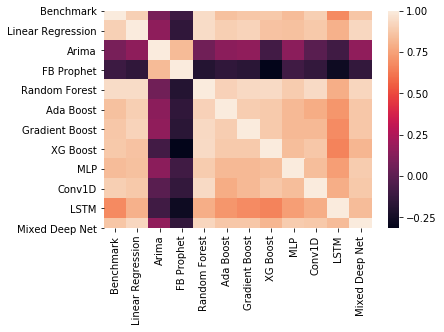

In [63]:
try: diff_models
except NameError: print('Run entire notebook before executing this cell.')
else: 
    algorithms = list(results.index)
    similarity = pd.DataFrame(diff_models).T.corr()
    similarity.index = algorithms
    similarity.columns = algorithms
    sns.heatmap(similarity)

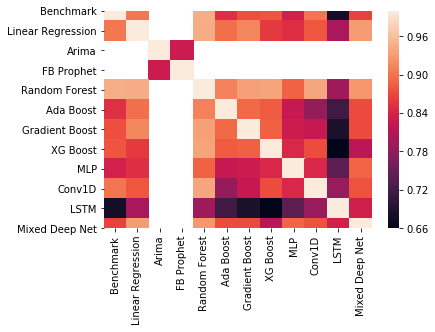

In [64]:
try: diff_models
except NameError: print('Run entire notebook before executing this cell.')
else: 
    # Hide ARIMA and Prophet
    sns.heatmap(similarity[similarity>.5])